<a href="https://colab.research.google.com/github/rahiakela/deep_learning_for_vision_systems/blob/master/3-convolutional-neural-networks/2_image_classification_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Image classification for colored images (CIFAR-10 dataset)

Let’s take a look at a complete end-to-end image classification project. In this project, we train a CNN to classify images from the [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset. CIFAR-10 is an established computer-vision dataset used for object recognition. It is a subset of the [80 million tiny images dataset](http://groups.csail.mit.edu/vision/TinyImages/) and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class.

## Setup

In [26]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

from tensorflow.keras.datasets import cifar10

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## Load the dataset

First step is to load the dataset into our train and test objects. Luckily, Keras provides the CIFAR dataset for us to load using load_data() method. All we have to do is to import
keras.datasets then load the data.

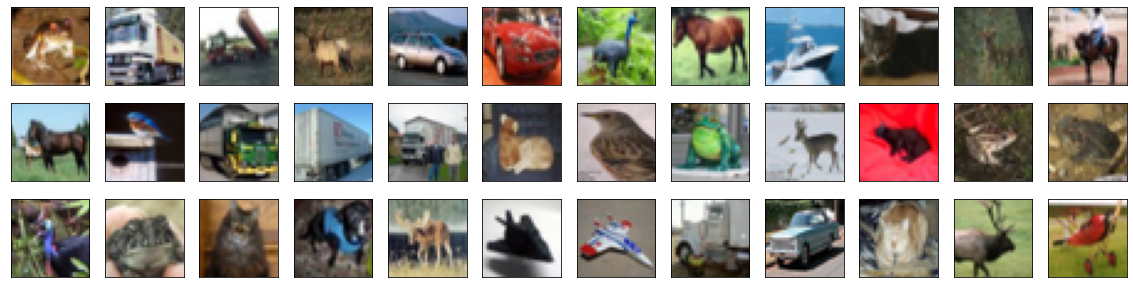

In [50]:
# load the pre-shuffled train and test data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# see first 36 images
fig = plt.figure(figsize=(20, 5))
for i in range(36):
  ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(x_train[i]))

## Image preprocessing

Based on your dataset and the problem you are solving, you will need to do some data cleanup and processing to get it ready for your learning model.

### Feature Scaling

In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales. Figure below shows Gradient Descent on a training set
where features 1 and 2 have the same scale (on the left), and on a training set where feature 1 has much smaller values than feature 2 (on the right).

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/features-scaling.png?raw=1' width='800'/>

**Note**

---
When using gradient descent, you should ensure that all features have a similar scale or else it will take
much longer to converge.

---







In [51]:
# convert to floating-point
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# save the original y_train and y_test
original_y_train = y_train
original_y_test = y_test

### Preparing the labels (one-hot encoding)

How computers process the input data (images) by converting them into numeric values in the form of matrix of pixel
intensity. But what about the labels? How are the labels understood by computers? 

Every image in our dataset has a specific label that explains (in text) how this image is categorized.

In this particular dataset for example, the labels are categorized by following 10 classes:

``
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
`` 

We need to convert these text labels into a form that could be processed by computers. Computers are good with numbers so we will do something called One-hot encoding. One hot encoding is a
process by which categorical variables are converted into a numeric form.

Say suppose the dataset is as follows:
<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/one-hot-encoding-1.png?raw=1' width='800'/>

After one-hot encoding we end up with the following:
<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/one-hot-encoding-2.png?raw=1' width='800'/>

Luckily, keras has a method that does just that for us:

In [52]:
# one-hot encode the labels
num_classes = len(np.unique(y_train))

y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

In [53]:
print(y_train[:5])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [54]:
print(y_train.shape, y_test.shape)

(50000, 10) (10000, 10)



---

*One-hot encoding converted the `(1xn)` labels vector to a labels matrix of dimensions `10xn`, where $n$ is the number of sample images. So, if we have a `1,000` images in our dataset, the labels vector will have the dimensions of `1x1000`.
After one-hot encoding, the labels matrix dimensions will be `1000x10`. That’s is why when we are defining our network architecture. we will make the output softmax layer contains `10` nodes. Where each node represent the probability of each class we have.*

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/one-hot-encoding-3.png?raw=1' width='800'/>


---




### Split dataset to train and validation

In addition to splitting our data into train and test datasets (step 1), it is a standard practice to further split the training data into train and validation datasets. Why? Because each split is used for a different purpose as follows:

* **Training Dataset**: The sample of data used to train the model.
* **Validation Dataset**: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
* **Test Dataset**: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/training-validation-test-sets.png?raw=1' width='800'/>

In [55]:
# break training set into training and validation sets
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# print shape of training set
print(f'x_train shape: {x_train.shape}')

x_train shape: (45000, 32, 32, 3)


In [56]:
# print number of training, validation, and test images
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')
print(x_valid.shape, 'validation samples')

(45000, 32, 32, 3) train samples
(10000, 32, 32, 3) test samples
(5000, 32, 32, 3) validation samples


In [57]:
# print number of training, validation, and test images
print(y_train.shape, 'train samples')
print(y_test.shape, 'test samples')
print(y_valid.shape, 'validation samples')

(45000, 10) train samples
(10000, 10) test samples
(5000, 10) validation samples


## Define the model architecture

Most of deep learning project consist of stacking together simple layers that will implement a form of data distillation. As we learned in this chapter, the main CNN layers are CONV, POOL, and FC layers. In addition to the activation functions.

**How do you decide on the network architecture?**

**How many convolutional layers to create? How many pooling layers?**

In my opinion, it is very helpful to read about some of the most popular architectures (Alexnet, Resnet, Inception), and extract the key ideas leading to the design decisions. Looking at how these state-of-the-art architectures are built and playing with your own projects will help you build an intuition on the CNN architecture the most suits the problem you are solving.

Here is what we need to know:
* The more layers you add the better (at least theoretically) your network will learn but this will come with the cost of increasing the computational and space complexity because it increases the number of parameters to optimize.
* The height and width of the image will decrease and the depth (or number of channels) will decrease.
* In general, two or three layers of 3x3 CONV layers followed by 2x2 POOL can be a good start. Add more CONV + POOL layers until your image is a reasonable size (say 4x4 or 5x5), then add a couple fully connected layers for the classification.
* There are several hyperparameters that you need to set up here (like filter, kernel_size, and padding). One common guideline is to not try to reinvent the wheel here setting the hyperparameters. But instead look in the literature to see what
hyperparameters usually work for others. And choose an architecture that worked well for someone else as a starting point then tune these hyperparameters to improve on it.


---

Important callout on hyperparameter tuning. I don’t want you to get hung up on hyperparameter setting when building
your first CNNs. One of the best ways for you to gain an intuition on how to put these layers and hyperparameters
together is to actually see a number of concrete examples of how other have done it. As I pointed out earlier, most of
your work as a deep learning engineer will be building your architecture and tuning the parameters. The main takeaway
that I want you to get out of this is:
* understand how the main CNN layers work (CONV, POOL, FC, Dropout) and why they are here
* Understand what each hyperparameter does (number of filters in the CONV layer, kernel_size, stride and padding)
* At the end, being able to implement any given architecture in keras. If you are able to replicate this project on your
own dataset, you are good to go.

---


For now, let’s move on with the architecture below which is inspired by AlexNet, a popular CNN architecture that won the ImageNet challenges in 2011.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/network-architecture-1.png?raw=1' width='800'/>

Let’s try a smaller version of AlexNet and see how it performs with our dataset. And based on the results, we can add more layers. Our architecture will be stacking 3 CONV layers and 2 FC
layers as follows:

$$CNN: INPUT => CONV_1 => POOL_1 => CONV_2 => POOL_2 => CONV_3 => POOL_3=> DO => FC => DO => FC (Softmax)$$


<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/network-architecture-2.png?raw=1' width='800'/>

As you can see, our network consists of three CONV and POOL layers + 2 FC layers (also called dense). Note that we will use the RELU activation function for all the hidden layers. In the last dense layer we will use a Softmax activation function with 10 nodes to return an array of 10 probability scores (summing to 1). Each score will be the probability that the current
image belong to our 10 image classes.

In [58]:
model = Sequential()

# INPUT=>CONV1=>POOL1
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))

# CONV2=>POOL2
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2))

# CONV3=>POOL3
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2))

# DO: Dropout layer to avoid overfitting with 30% rate
model.add(Dropout(rate=0.3))

# Flatten the last feature map into a vector of features
model.add(Flatten())

# FC
model.add(Dense(500, activation='relu'))
# Add second DO layer to avoid overfitting with 40% rate
model.add(Dropout(rate=0.4))

# Output layer with 10 nodes and softmax activation to give probabilities to the 10 classes
model.add(Dense(10, activation='softmax'))

# summary of the model architecture
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        208       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)          8256      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 4, 64)         

As you can see, our model has 528,054 parameters (weights and biases) to train.

### Compile the model

The last step before training our model is to define three more hyperparameters: loss function, optimizer, and metrics to monitor during training and testing.

* **Loss function**: how the network will be able to measure its performance on the training data.
* **Optimizer**: the mechanism that the network will use to optimize its parameters (weights and biases) to yield the minimum loss value. It is usually one of the variants of stochastic gradient descent (SGD).
* Metrics to monitor during training and test.

In [63]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the model

We are now ready to train the network. In Keras, this is done via a call to the network’s .fit() method (as in fit the model to the training data).

In [64]:
# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_valid, y_valid), callbacks=[checkpointer], verbose=2, shuffle=True)

Epoch 1/100
1407/1407 - 9s - loss: 1.6096 - accuracy: 0.4181 - val_loss: 1.5076 - val_accuracy: 0.4438

Epoch 00001: val_loss improved from inf to 1.50760, saving model to model.weights.best.hdf5
Epoch 2/100
1407/1407 - 8s - loss: 1.2807 - accuracy: 0.5430 - val_loss: 1.2331 - val_accuracy: 0.5598

Epoch 00002: val_loss improved from 1.50760 to 1.23309, saving model to model.weights.best.hdf5
Epoch 3/100
1407/1407 - 8s - loss: 1.1541 - accuracy: 0.5917 - val_loss: 1.1562 - val_accuracy: 0.5956

Epoch 00003: val_loss improved from 1.23309 to 1.15621, saving model to model.weights.best.hdf5
Epoch 4/100
1407/1407 - 8s - loss: 1.0871 - accuracy: 0.6211 - val_loss: 1.0327 - val_accuracy: 0.6400

Epoch 00004: val_loss improved from 1.15621 to 1.03271, saving model to model.weights.best.hdf5
Epoch 5/100
1407/1407 - 8s - loss: 1.0450 - accuracy: 0.6359 - val_loss: 0.9415 - val_accuracy: 0.6792

Epoch 00005: val_loss improved from 1.03271 to 0.94152, saving model to model.weights.best.hdf5
Epoc

### Observe the network behavior

Looking at the verbose above will help you analyze how your network is performing and will give you pointers on which knob (hyperparameter) to tune.

For now, let’s look at the most important giveaways from the above verbose:

* “loss” and “acc” are the error and accuracy values for the training data. “val_loss” and “val_acc” are the error and accuracy values for the validation data.
* Look at the val_loss and val_acc values after each epoch. Ideally we want the val_loss value to be decreasing and the val_acc to be increasing. This means that the network is actually learning after each epoch.
* From epochs 1 to 6, you can see that the model is saving the weights after each epoch because the validation loss value is improving. So by the end of each epoch, we save the weights which are considered the best weights so far.
* At epoch #7 the val_loss went up to 1.1300 from 0.9445 which means that it did not improve. So, the network did not save the weights at this epoch. If you stop the training now and load the weights from epoch #6, you will get the best results that you achieved during the training.
* Same for epoch #8, the val_loss decrease, so the network saves the weights as best values. And at epoch #9 no improvement and so forth.
* If you stop your training after 12 epochs and load the best weights. The network will load the weights saved after epoch #10 at val_loss = 0.9157 and validation accuracy = 0.6936. This means that you can expect to get accuracy on the test data close to 69%.


---

One tip is to keep your eyes on the following popular phenomenons:

**val_los is oscillating**: if the val_loss is oscillating up and down then you might want to decrease the learning rate
hyperparameter. For example, if you see the val_loss going from 0.8 to 0.9 to 0.7 to 1.0 and so on, this might mean
that your learning rate is too high to descent the error mountain. Try decreasing the learning rate and let the network
train for longer time.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep_learning_for_vision_systems/learning-rate.png?raw=1' width='800'/>

**val_loss is not improving (underfitting)**: if the val_loss is not decreasing, this might mean that your model is too simple
to fit the data (underfitting). Then you might want to build a more complex model by adding more hidden layers to help
the network fit the data.

**Overfitting**: if the “loss” value is decreasing and the “val_loss” stopped improving, this means that you network started to overfit the training data and failing to decrease the error for the validation data. In this case, consider adding using one of the techniques to prevent overfitting like dropout layers.

---



### Load the model with the best val_acc

In [65]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

### Evaluate the model

The last step is to evaluate our model and calculate the accuracy value in percentage of how many times our model is correct in predicting the image classification.

In [66]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.6777999997138977


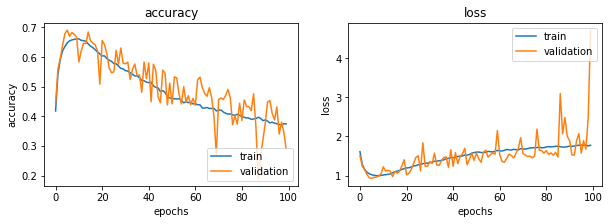

In [67]:
xs = range(len(history.history['accuracy']))

plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.plot(xs, history.history['accuracy'], label='train')
plt.plot(xs, history.history['val_accuracy'], label='validation')
plt.legend(loc='lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy')

plt.subplot(1, 2, 2)
plt.plot(xs, history.history['loss'], label='train')
plt.plot(xs, history.history['val_loss'], label='validation')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss')

plt.show()

You will get an accuracy of about 70%. That is not bad. But we
can do a lot better. Try to play with the CNN architecture by adding more CONV + POOL layers and see if you can improve your model.

### Visualize Some Predictions

This may give you some insight into why the network is misclassifying certain objects.

In [68]:
# get predictions on the test set
y_hat = model.predict(x_test)

# define text labels (source: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

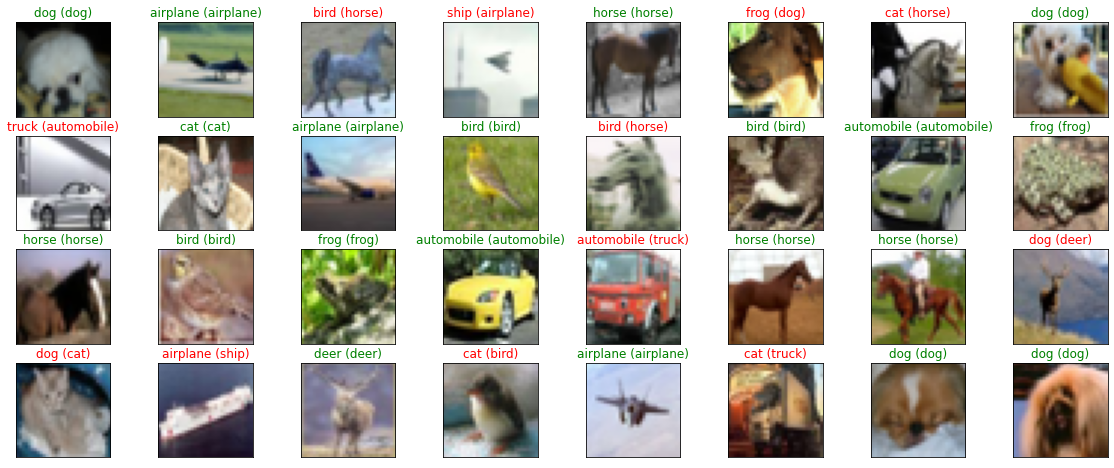

In [69]:
# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]), color=("green" if pred_idx == true_idx else "red"))